<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#load-some-data" data-toc-modified-id="load-some-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>load some data</a></span></li><li><span><a href="#check-out-the-power-spectrum" data-toc-modified-id="check-out-the-power-spectrum-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>check out the power spectrum</a></span></li><li><span><a href="#apply-notch-filters-@-60hz,-etc" data-toc-modified-id="apply-notch-filters-@-60hz,-etc-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>apply notch filters @ 60hz, etc</a></span></li><li><span><a href="#apply-bandpass-filters-for-each-freq-band" data-toc-modified-id="apply-bandpass-filters-for-each-freq-band-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>apply bandpass filters for each freq band</a></span></li><li><span><a href="#extract-the-phase-and-magnitude-from-the-filtered-signal" data-toc-modified-id="extract-the-phase-and-magnitude-from-the-filtered-signal-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>extract the phase and magnitude from the filtered signal</a></span></li><li><span><a href="#smooth-and-normalize-the-magnitude" data-toc-modified-id="smooth-and-normalize-the-magnitude-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>smooth and normalize the magnitude</a></span></li></ul></div>

For practice, filter a sample LFP channel

In [1]:
import numpy as np
import mat73
from os.path import join as pjoin
import scipy.signal as signal
import matplotlib.pyplot as plt

## load some data

In [2]:
data_dir = "data_clean"
fname_lfp = "George00_rec14_01282021-LFP.mat"

lfp_mat = mat73.loadmat(pjoin(data_dir, fname_lfp))

In [3]:
# extract one channel
freq = 1000 # Hz 
ts = lfp_mat["lfp_ts"]/freq # time in seconds
channel = lfp_mat["FP065"] # mV on this channel


## check out the power spectrum

In [4]:
# make periodigram from the entire 2 hr timeseries
f1, Pxx_den1 = signal.periodogram(channel, freq)

(1e-09, 1000000.0)

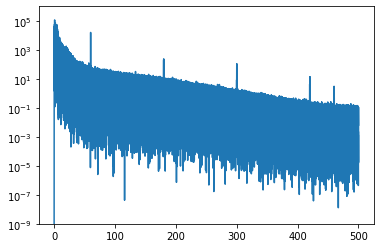

In [5]:
fig = plt.figure()
ax = fig.add_subplot()

ax.semilogy(f1, Pxx_den1)
ax.set_ylim((10e-10, 10e5))

## apply notch filters @ 60hz, etc

Text(0, 0.5, 'filter')

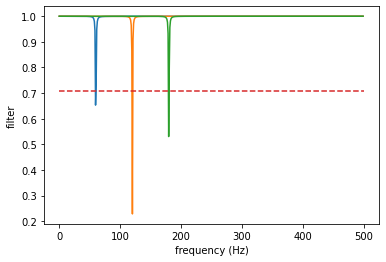

In [9]:
# build the filters
notches = [60, 120, 180]
notch_filts = [signal.iirnotch(n, n, freq) for n in notches]
notch_vis = [signal.freqz(n[0], n[1], fs=freq) for n in notch_filts]

fig, ax = plt.subplots()

for n in notch_vis:
    ax.plot(n[0], abs(n[1]))
    
ax.plot([0, 0.5 * freq], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("filter")

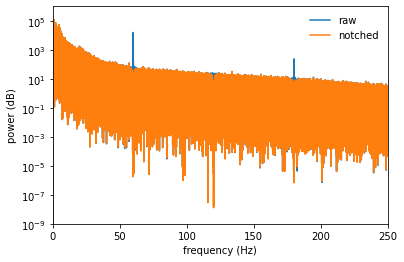

In [10]:
# show the filtered signal
notched = channel
for f in notch_filts:
    notched = signal.filtfilt(f[0], f[1], notched)
    
f2, Pxx_den2 = signal.periodogram(notched, freq)

fig = plt.figure()
ax = fig.add_subplot()

ax.semilogy(f1, Pxx_den1)
ax.semilogy(f2, Pxx_den2)
ax.set_ylim((10e-10, 10e5))
ax.set_xlim((0, 250))
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("power (dB)")

ax.legend(["raw","notched"], frameon=False)

## apply bandpass filters for each freq band

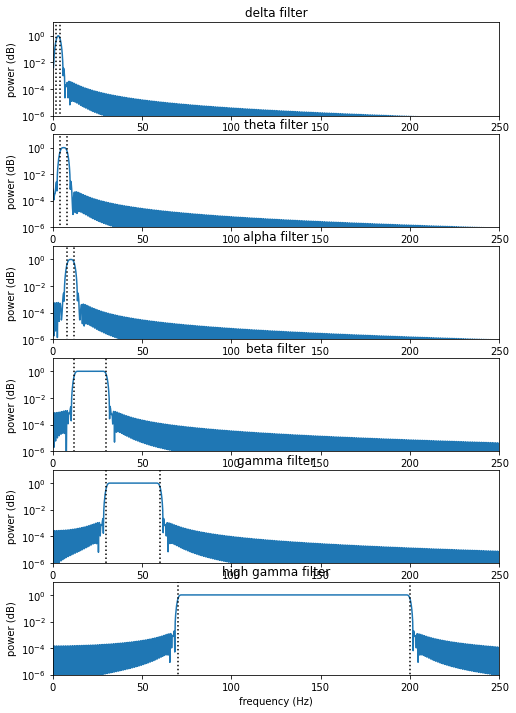

In [11]:
# build the filters
bands = [[2, 4], [4, 8], [8, 12], [12, 30], [30, 60], [70, 200]]
band_names = ["delta", "theta", "alpha", "beta", "gamma", "high gamma"]
band_filts = [signal.firwin(1000, [b[0], b[1]], pass_zero=False, fs=freq) for b in bands]
band_vis = [signal.freqz(b, 1, fs=freq, worN=2000) for b in band_filts]

fig = plt.figure(figsize=(8, 12))

for b in range(6):
    ax = fig.add_subplot(6, 1, b + 1)
    ax.semilogy(band_vis[b][0], abs(band_vis[b][1]))
    ax.plot([bands[b][0], bands[b][0]], [0, 10], 'k:')
    ax.plot([bands[b][1], bands[b][1]], [0, 10], 'k:')
    ax.set_xlim([0, 250])
    ax.set_ylim([10e-7, 10e0])
    ax.set_xlabel("frequency (Hz)")
    ax.set_ylabel("power (dB)")
    ax.set_title(band_names[b] + " filter")

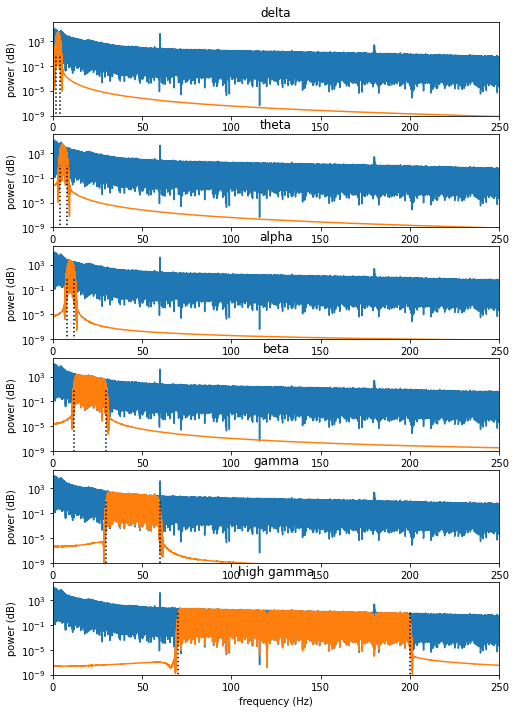

In [12]:
# show filtered signal
fig = plt.figure(figsize=(8, 12))

bandpassed = []
for b in range(6):
    bandpassed.append(signal.filtfilt(band_filts[b], 1, notched))
    f_band, Pxx_band = signal.periodogram(bandpassed[b], freq)
    
    ax = fig.add_subplot(6, 1, b + 1)
    ax.semilogy(f1, Pxx_den1)
    ax.semilogy(f_band, Pxx_band)
    ax.plot([bands[b][0], bands[b][0]], [0, 10], 'k:')
    ax.plot([bands[b][1], bands[b][1]], [0, 10], 'k:')
    ax.set_ylim((10e-10, 10e5))
    ax.set_xlim((0, 250))
    ax.set_xlabel("frequency (Hz)")
    ax.set_ylabel("power (dB)")
    ax.set_title(band_names[b]) 
    

## extract the phase and magnitude from the filtered signal

In [13]:
# get the analytic signal with hilbert transform
analytic = [signal.hilbert(b) for b in bandpassed]
mag = [np.abs(a) for a in analytic]
phs = [np.angle(a) for a in analytic]

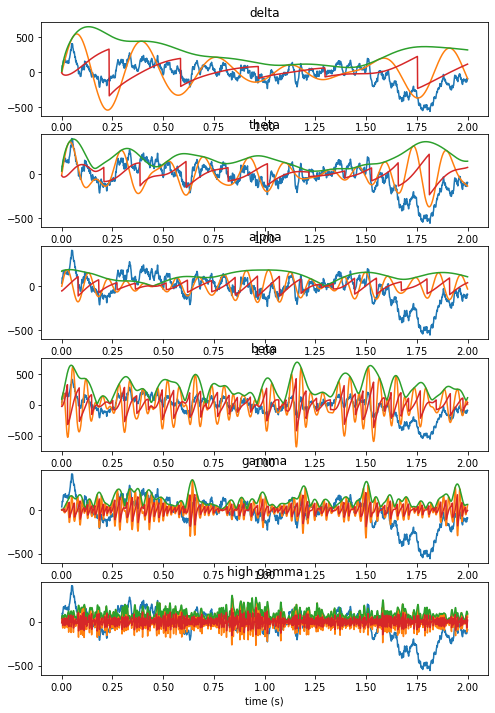

In [14]:
fig = plt.figure(figsize=(8, 12))
n = 2000 # how many time points to show
for b in range(6):
    ax = fig.add_subplot(6, 1, b + 1)
    ax.plot(ts[:n], notched[:n])
    ax.plot(ts[:n], 5*bandpassed[b][:n])
    ax.plot(ts[:n], 5*mag[b][:n])
    ax.plot(ts[:n], phs[b][:n]*mag[b][:n])
    ax.set_xlabel("time (s)")
    ax.set_title(band_names[b])

## smooth and normalize the magnitude

In [15]:
box = signal.boxcar(49)/49

mag_smooth = [np.convolve(m, box, 'same') for m in mag]

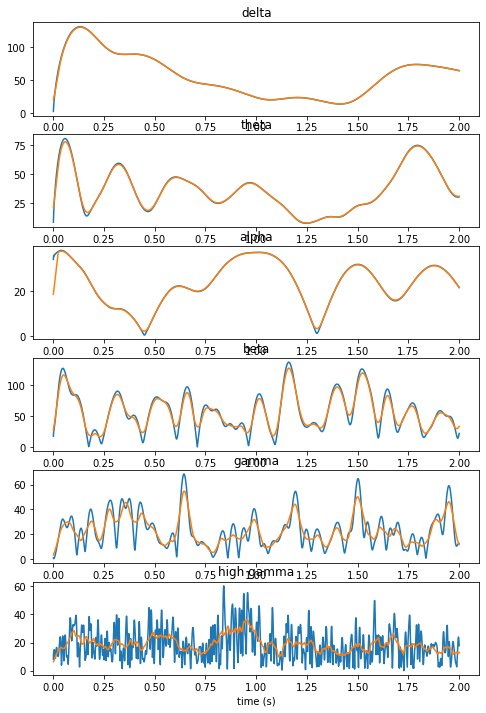

In [16]:
fig = plt.figure(figsize=(8, 12))
n = 2000 # how many time points to show
for b in range(6):
    ax = fig.add_subplot(6, 1, b + 1)
    ax.plot(ts[:n], mag[b][:n])
    ax.plot(ts[:n], mag_smooth[b][:n])
    ax.set_xlabel("time (s)")
    ax.set_title(band_names[b])